In [1]:
#------------------------------------------------------------------------------------------------------------------------------------------
# basic setup of the notebook
#------------------------------------------------------------------------------------------------------------------------------------------
import numpy as np
import numba as nb
from numba import njit, prange
from numba.experimental import jitclass
import pickle

from mpmath import *
mp.dps = 200;mp.pretty = True
import tomllib
from pip._vendor import tomli
import sys, os
from joblib import Parallel, delayed
import multiprocess as mp
from concurrent.futures import ProcessPoolExecutor
import scipy as sp
from scipy import *
import faulthandler
faulthandler.enable()
sys.path.append('./code')
from fit_drivers import *
from minimizer import *
from fit_functions import *
from output_functions import *
from general_stats import *
from jpac_colors import *
import fit_drivers, minimizer, fit_functions, output_functions, general_stats  

import math as mp
import timeit
import time

# everything in iminuit is done through the Minuit object, so we import it
from iminuit import Minuit
from iminuit import minimize
import time
from iminuit.util import describe
from typing import Annotated

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares

# display iminuit version
import iminuit
print("iminuit version:", iminuit.__version__)

from matplotlib import pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

iminuit version: 2.30.1


In [11]:
#------------------------------------------------------------------------------------------------------------------------------------------
# Importing fixed params for analysis
#------------------------------------------------------------------------------------------------------------------------------------------

with open('ini_files/W_analysis_L32_xi=1_pole.toml', "rb") as f:
    params = tomli.load(f)

with open('ini_files/basic_setup_pole.toml', "rb") as f2:
    params2 = tomli.load(f2)

for i in params:
     params['{}'.format(i)].update(params2['{}'.format(i)])


who            = params['creator']['who']
  
  
path           = params['paths_to_files']['base_path']
mainpath       = '{}{}'.format(path,params['paths_to_files']['mainpath'])
resultspath    = '{}{}'.format(path,params['paths_to_files']['resultspath'])
resultsdir     = '{}{}'.format(path,params['paths_to_files']['resultsdir'])
plotsdir       = '{}{}'.format(path,params['paths_to_files']['plotsdir'])
Gcplotsdir     = '{}{}'.format(path,params['paths_to_files']['Gcplotsdir'])
sizelabel      = params['paths_to_files']['sizelabel']      
  
  
corrtype       = params['correlators']['corrtype']  
xi             = params['correlators']['xi']
beta           = params['correlators']['beta']
betanorm       = params['correlators']['betanorm']
Lextent        = params['correlators']['Lextent']
Textent        = params['correlators']['Textent']
size           = params['correlators']['size']
Ncfgs          = params['correlators']['Ncfgs']

als            = params['correlators']['als']
  
dini_Gc        = params['minimization_parameters']['dini_Gc']
dstop_Gc       = params['minimization_parameters']['dstop_Gc']
dmindata_Gc    = params['minimization_parameters']['dmindata_Gc']
dini_Vr        = params['minimization_parameters']['dini_Vr']
dstop_Vr       = params['minimization_parameters']['dstop_Vr']
dmindata_Vr    = params['minimization_parameters']['dmindata_Vr']
dfin_Gc        = params['minimization_parameters']['dfin_Gc']
dfin_Vr        = params['minimization_parameters']['dfin_Vr']
reuse          = params['minimization_parameters']['reuse']
inv_first      = params['minimization_parameters']['inv_first']
mcalls         = params['minimization_parameters']['mcalls']
mtol           = params['minimization_parameters']['mtol']
inipars_Gc     = params['minimization_parameters']['inipars_GC']
variants_Gc    = params['minimization_parameters']['variants_GC']
jackkl         = params['minimization_parameters']['jackkl']
xiini          = params['minimization_parameters']['xiini']
xifin          = params['minimization_parameters']['xifin']   
fileini        = params['minimization_parameters']['fileini']                         
filefin        = params['minimization_parameters']['filefin']
datatype_Gc    = params['minimization_parameters']['datatype_Gc']
model_Gc       = params['minimization_parameters']['model_Gc']
model_Vr       = params['minimization_parameters']['model_Vr']
datatype_Vr    = params['minimization_parameters']['datatype_Vr']
inipars_Vr     = params['minimization_parameters']['inipars_Vr']
variants_Vr    = params['minimization_parameters']['variants_Vr']
multiprocess   = params['minimization_parameters']['multiprocess']
cov_freeze     = params['minimization_parameters']['cov_freeze']
improve        = params['minimization_parameters']['improve']
multistart     = params['minimization_parameters']['multistart']
  

clean          = params['extra']['clean']
cutoff_ma      = params['extra']['cutoff_ma']
norm           = params['extra']['norm']
no_corrs       = params['extra']['no_corrs']
no_valid_check = params['extra']['no_valid_check']


gev_m1_tofm=5.068
als=np.array(als)/gev_m1_tofm
als_orig=np.array(als)*gev_m1_tofm

In [12]:
#------------------------------------------------------------------------------------------------------------------------------------------
#This is the only part that varies between Sebastian's and Wyatt's Lattices, the paths/readings
#------------------------------------------------------------------------------------------------------------------------------------------

# Create results folders if they do not exist
if os.path.exists(resultsdir)==False:
    os.mkdir(resultsdir)
if os.path.exists(plotsdir)==False:
    os.mkdir(plotsdir)
if os.path.exists(Gcplotsdir)==False:
    os.mkdir(Gcplotsdir)    


# Clean results folder?
if clean == 1:
    os.system('rm -rf {}/*'.format(plotsdir))
    os.system('rm -rf {}/*'.format(resultsdir))  
    os.system('rm -rf {}/*'.format(Gcplotsdir)) 


for k in range(len(xi)):
    if os.path.exists('{}{}'.format(resultspath,xi[k]))==False:
        os.mkdir('{}{}'.format(resultspath,xi[k]))
    if os.path.exists('{}/xi={}'.format(Gcplotsdir,xi[k]))==False:
        os.mkdir('{}/xi={}'.format(Gcplotsdir,xi[k]))

        
#------------------------------------------------------------------------------------------------------------------------------------------
# Read raw data and prepare accordingly
#------------------------------------------------------------------------------------------------------------------------------------------
         

# Data used in the analysis
datam=[]
for k in range(len(xi)):
    dataint=[]
    for j in range(len(beta)):
        dataint.append(np.genfromtxt('{}{}/L{}_b{}_xi{}_{}.dat'.format(mainpath,xi[k],int(sizelabel),beta[j],xi[k],corrtype)))
    datam.append(dataint)
    
# Collect completed configurations from raw data    
data=[]
for k in range(len(xi)):
    dataint=[]
    for j in range(len(datam[k])):
        if (len(np.array(collect_configs(datam[k][j],Lextent,Textent).trans_S()))==0):
            dataint.append(np.array(collect_configs(datam[k][j],Lextent,Textent).trans_W()))
        else:
            dataint.append(np.array(collect_configs(datam[k][j],Lextent,Textent).trans_S()))
    data.append(dataint)

      

nconfigs=[]
for k in range(len(xi)):
    nint=[]
    for j in range(len(beta)):
        nint.append(int(len(data[k][j])/size[k]))
        print(int(len(data[k][j])/size[k]))
        nconfigs.append(int(len(data[k][j])/size[k]))  

print(min(nconfigs),max(nconfigs))  
print(beta)

396
396 396
[644]


In [13]:
x=0
k=0
r=0
pos=0

jackkl=100000
jump_configs=1

mcalls=10000
mtol=0.00001

totaltraj=int(len(data[x][k])/size[k])
Nt=Textent

Gc=np.zeros((int(totaltraj/jump_configs),Nt))
Gc2=np.zeros((int(totaltraj/jump_configs),Nt))
for i in range(int(totaltraj/jump_configs)):
    index=jump_configs*i
    Gc[[i]]=data[x][k][range(index*Nt,(index+1)*Nt),[r]]
    Gc2[[i]]=data[x][k+1][range(index*Nt,(index+1)*Nt),[r]]

for time in range(len(Gc[0])):
    shift=0.1
    data_t = np.ones(len(Gc[:,time]))*time+1
    plt.scatter(data_t,Gc[:,time],color=jpac_blue)
    plt.scatter(data_t+shift,Gc2[:,time],color=jpac_red)
    plt.xlim(0,7.5)

IndexError: list index out of range

array([1.33167687e+00, 7.39328891e-01, 4.12173697e-01, 2.30101571e-01,
       1.28516128e-01, 7.18040674e-02, 4.01265620e-02, 2.23918613e-02,
       1.25067093e-02, 6.98524931e-03, 3.91726002e-03, 2.17525600e-03,
       1.20865898e-03, 6.62120324e-04, 3.68739372e-04, 2.20255566e-04])

array([ 4161.80854999, 10843.92592839, 22847.2759508 , 41236.01672957,
       58477.43694154, 63620.58007023, 70046.14561113, 78375.9262984 ,
       79057.10460337, 79368.64441544, 80773.26432824, 81102.28947974,
       81321.95442416, 83068.29754515, 84573.59276072, 84941.47144332])

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 4.019 (χ²/ndof = 2.0)      │             Nfcn = 5951              │
│ EDM = 10.7 (Goal: 2e-08)         │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │     Covariance FORCED pos. def.      │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │  0.0043   │  0.0014   │            │            │         │         │       │
│ 1 │ x1   │  2.3570   │  0.0013   │            │            │         │         │       │
│ 2 │ x2   │-582.00e-3 │  0.14e-3  │            │            │         │         │       │
│ 3 │ x3   │   0.00    │   0.04    │            │            │         │         │       │
│ 4 │ x4   │   -0.95   │   0.13    │            │            │         │         │       │
│ 5 │ x5   │  -0.042   │   0.008   │            │            │         │         │       │
│ 6 │ x6   │   0.05    │   0.09    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────────────────────────────────────────────────────────┐
│    │        x0        x1        x2        x3        x4        x5        x6 │
├────┼───────────────────────────────────────────────────────────────────────┤
│ x0 │  1.93e-06   -0.7e-6 -0.093e-6  -55.9e-6  144.0e-6   -9.5e-6  -68.5e-6 │
│ x1 │   -0.7e-6  1.81e-06 -0.031e-6   20.6e-6  -73.9e-6    3.6e-6   47.1e-6 │
│ x2 │ -0.093e-6 -0.031e-6  1.88e-08  3.075e-6 -6.542e-6  0.518e-6  2.321e-6 │
│ x3 │  -55.9e-6   20.6e-6  3.075e-6   0.00177   -0.0047   0.31e-3    0.0023 │
│ x4 │  144.0e-6  -73.9e-6 -6.542e-6   -0.0047    0.0161  -0.81e-3    -0.004 │
│ x5 │   -9.5e-6    3.6e-6  0.518e-6   0.31e-3  -0.81e-3  5.98e-05   0.39e-3 │
│ x6 │  -68.5e-6   47.1e-6  2.321e-6    0.0023    -0.004   0.39e-3   0.00723 │
└────┴───────────────────────────────────────────────────────────────────────┘

array([ 4.29178475e-03,  2.35696294e+00, -5.82002771e-01,  4.66149605e-04,
       -9.52395965e-01, -4.17665384e-02,  5.06604917e-02])

<ErrorbarContainer object of 3 artists>

Text(0.88, 0.8, '$\\chi^2/ndof=2.0$')

Text(0.88, 0.7, '$E_0=0.582\\pm 0.000$')

Text(0.88, 0.65, '$dlog(0)=0.600\\pm 0.016$')

Text(0.5, 0, '$T$ ')

Text(0, 0.5, '$G(R,T)$')

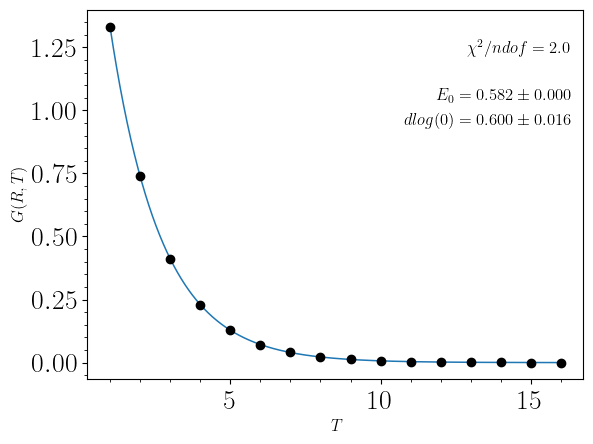

In [15]:
x=0
k=0
r=3
pos=0

jackkl=100000
jump_configs=1

mcalls=10000
mtol=0.00001

totaltraj=int(len(data[x][k])/size[k])
Nt=Textent

Gc=np.zeros((int(totaltraj/jump_configs),Nt))
for i in range(int(totaltraj/jump_configs)):
    index=jump_configs*i
    Gc[[i]]=data[x][k][range(index*Nt,(index+1)*Nt),[r]]
    
#logG=np.log(ratio(trim_negative(Gc).trimmed()).val())


# Get average over all data, we will then replicate for every Jackknife sample to get errors

gdata=jackknife(Gc,jackkl).sample()
lt=len(Gc[0])
dfin=min(lt,100)
data_t   = np.linspace(1, lt, lt)
data_2t  = np.linspace(1, 2*lt-1, 2*lt-1)
if pos==0:
    data_y   = ensemble_stat(gdata).mean()
else:
    data_y   = gdata[pos]
data_cov = ensemble_stat(jackknife(gdata,jackkl).up()).rcov()
data_err = np.sqrt(np.diagonal(ensemble_stat(jackknife(gdata,jackkl).up()).rcov()))

data_y
np.sort(np.sqrt(np.diag(improved_inverse_covariance(data_cov))))

data_covf = np.identity(lt)
for i in range(len(np.sqrt(np.diag(data_cov)))):
    for j in range(len(np.sqrt(np.diag(data_cov)))):
        data_covf[i][j]*=np.sqrt(np.diag(data_cov))[i]*np.sqrt(np.diag(data_cov))[j]

tini=1
tfin=9

funfit='nb_exp_np_pole'
inipars=[0.0,1.,1.,0.1,1.0,0.1,0.1]
#funfit='nb_exp_np'
#inipars=[-0.46355412, -2.793052 ]
 

m=RepeatSingleFit(data_t, data_y, data_cov, tini, tfin, inipars, funfit , mcalls, mtol,0,1,0,0,10,10)

fit=m.minimize()
fit
np.array(fit.values)

if (len(inipars)%2==0):
    mass  = np.abs(np.array(fit.values)[1])
    emass = np.array(fit.errors)[1]
else:
    mass  = np.abs(np.array(fit.values)[2])
    emass = np.array(fit.errors)[2]   


dlog=loglimG(0,*np.array(fit.values)[1:])
edlog=prop_err(0,'loglimG',np.array(fit.values)[1:],np.array(fit.errors)[1:],np.array(fit.covariance.correlation())[1:,1:])[0]

data_t_plot=np.linspace(data_t[0],data_t[-1],1000)

plt.errorbar(data_t, data_y, data_err, fmt="ok", label="data")
plt.plot(data_t_plot, eval(funfit)(data_t_plot, *fit.values), label="fit")

#plt.yscale('log')

plt.figtext(0.88, 0.8, 
                '$\\chi^2/ndof={:.1f}$'.format(fit.fval/fit.ndof), 
                horizontalalignment ="right",  
                verticalalignment ="center",  
                wrap = True, fontsize = 12,  
                color ="black")
plt.figtext(0.88, 0.7, 
                '$E_0={:.3f}\\pm {:.3f}$'.format(mass,emass), 
                horizontalalignment ="right",  
                verticalalignment ="center",  
                wrap = True, fontsize = 12,  
                color ="black")
plt.figtext(0.88, 0.65, 
                '$dlog(0)={:.3f}\\pm {:.3f}$'.format(dlog,edlog), 
                horizontalalignment ="right",  
                verticalalignment ="center",  
                wrap = True, fontsize = 12,  
                color ="black")
plt.xlabel("$T$ ",fontsize=12)
plt.ylabel("$G(R,T)$",fontsize=12, rotation=90, loc='center')
plt.show()

In [6]:
Gc[:,0]
np.mean(Gc[:,0])
np.max(Gc[:,0])

array([1.21117458, 1.28138604, 1.17533155, ..., 1.25877697, 1.24069075,
       1.28731942])

np.float64(1.2513963643009975)

np.float64(1.418929864005)

In [7]:
gdata=jackknife(Gc,jackkl).sample()[:,0]
gdata
np.max(gdata)

array([1.25141655, 1.25138132, 1.25143453, ..., 1.25139266, 1.25140174,
       1.25137834])

np.float64(1.2514917829298533)

In [8]:
jackknife(gdata,jackkl).up()
np.max(jackknife(gdata,jackkl).up())

array([1.21117458, 1.28138604, 1.17533155, ..., 1.25877697, 1.24069075,
       1.28731942])

np.float64(1.418929864005098)

In [9]:
with open("../S_correlators_L32/Gc_plots/xi=1/3_nb_exp_np_pole_exp_AIC_list_ti1_0_tfin16_tmin12_beta=225_R=1_nocorrs=0_g", "rb") as fp:   # Unpickling
   b = pickle.load(fp)

In [10]:
gdata1=b.ordered()[0][4][:,1]
gdata2=b.ordered()[6][4][:,1]

Gdata1=jackknife(gdata1,jackkl).pup()
Gdata2=jackknife(gdata2,jackkl).pup()
weights=[0.9,0.1]

(jackknife(gdata1**2).fmean()-jackknife(gdata1).fmean()**2)*(len(gdata1)-1)
jackknife(Gdata1**2).fmean()-jackknife(Gdata1).fmean()**2


(jackknife(gdata2**2).fmean()-jackknife(gdata2).fmean()**2)*(len(gdata2)-1)
jackknife(Gdata2**2).fmean()-jackknife(Gdata2).fmean()**2


gdata=gdata1*weights[0]+gdata2*weights[1]
gdatasq=gdata1**2*weights[0]+gdata2**2*weights[1]
Gdata=Gdata1*weights[0]+Gdata2*weights[1]
Gdatasq=Gdata1**2*weights[0]+Gdata2**2*weights[1]

gdata.mean()
Gdata.mean()

len(gdata)
(jackknife(gdatasq).fmean()-jackknife(gdata).fmean()**2)*(len(gdata)-1)
jackknife(Gdatasq).fmean()-jackknife(Gdata).fmean()**2
(jackknife(gdata**2).fmean()-jackknife(gdata).fmean()**2)*(len(gdata)-1)
jackknife(Gdata**2).fmean()-jackknife(Gdata).fmean()**2

array([0.00010075])

array([0.00010075])

array([0.00010071])

array([0.00010071])

np.float64(0.5142635155172564)

np.float64(0.5142635155172567)

1000

array([0.00010122])

array([0.00010075])

array([0.0001007])

array([0.0001007])

In [11]:
jackknife(gdata1).upcov()+jackknife(gdata1).fmean()**2
jackknife(Gdata1**2).fmean()

array([0.26457516])

array([0.26457516])

In [71]:
Gc=np.zeros((int(totaltraj/jump_configs),Nt))
for i in range(int(totaltraj/jump_configs)):
    index=jump_configs*i
    Gc[[i]]=data[x][k][range(index*Nt,(index+1)*Nt),[r]]
    
#logG=np.log(ratio(trim_negative(Gc).trimmed()).val())


# Get average over all data, we will then replicate for every Jackknife sample to get errors

gdata1=jackknife(jackknife(Gc,jackkl).sample()[:,0]).pup()
gdata2=jackknife(jackknife(Gc,jackkl).sample()[:,9]).pup()

np.cov(gdata1,gdata2)
np.corrcoef(gdata1,gdata2)


np.cov(add_gaussian_noise(gdata1,1e-7),add_gaussian_noise(gdata2,1e-8))-np.cov(gdata1,gdata2)
np.cov(add_gaussian_noise2(gdata1,1e-7),add_gaussian_noise2(gdata2,1e-8))-np.cov(gdata1,gdata2)

array([[1.33397993e-06, 1.12768105e-07],
       [1.12768105e-07, 2.31189511e-08]])

array([[1.        , 0.64213682],
       [0.64213682, 1.        ]])

array([[ 9.27380228e-08, -2.61242528e-11],
       [-2.61242528e-11,  1.05894645e-08]])

array([[ 1.28327604e-07, -9.22688373e-10],
       [-9.22688373e-10,  9.59603365e-09]])

In [78]:
val=Gdata1.mean()*weights[0]+Gdata2.mean()*weights[1]
eval=(jackknife(Gdata1**2).fmean()*weights[0]+jackknife(Gdata2**2).fmean()*weights[1])

val2=gdata1.mean()*weights[0]+gdata2.mean()*weights[1]
eval2=((jackknife(gdata1).upcov()+jackknife(gdata1).fmean()**2)*weights[0]+(jackknife(gdata2).upcov()+jackknife(gdata2).fmean()**2)*weights[1])


eval-val**2
eval2-val2**2

array([0.00010083])

array([0.10071575])

In [156]:
def get_near_psd(A):   # As explained in N.J. Higham, "Computing a nearest symmetric positive semidefinite matrix" (1988): https://doi.org/10.1016/0024-3795(88)90223-6
    if (len(np.shape(A))<2):
        result=A
    else:
        C=(A + np.transpose(A))/2
        eigval, eigvec = np.linalg.eig(C)
        if (np.min(eigval)<0):
            print('Negative eig found==',np.min(eigval))
        eigval[eigval < 0] = 0
        result=np.transpose(eigvec).dot(np.diag(eigval)).dot(eigvec)
        #result=(result+np.transpose(result))/2
    return result

try_matrix=data_cov_R

np.linalg.svd(try_matrix)[1]
np.linalg.svd(get_near_psd(try_matrix))[1]

array([1.37933672e-05, 4.35990770e-08, 3.11586735e-09, 1.01556374e-09,
       4.73928161e-10, 3.33576786e-10, 2.49249539e-10, 1.83717921e-10,
       8.16209918e-22, 6.04466121e-22])

Negative eig found== -8.183877357811934e-22


array([1.37933672e-05, 4.35990770e-08, 3.11586735e-09, 1.01556374e-09,
       4.73928161e-10, 3.33576854e-10, 2.49249489e-10, 1.83717921e-10,
       8.15941334e-22, 1.29402036e-22])

In [354]:
def improved_inverse_covariance2(A):    # It computes the Moore-Penrose pseudo-inverse. It produces a SVD decomp and inverse, which resets small singular values via a condition related to machine precision. If no small singular values are found, it provides with the actual SVD method inversion
    rtol=len(A)*np.finfo(np.float64).eps
    svd=sp.linalg.svd(A)
    eig_sign=np.round(np.real(sp.linalg.eig(A)[0])/np.abs(np.real(sp.linalg.eig(A)[0])))
    singular_value=svd[1][-1]/svd[1][0]
    #print(singular_value,rtol)
    if (singular_value>rtol):
        UT=np.transpose(svd[0])
        inv_list=1/svd[1]*eig_sign
        inv_list[inv_list < 0]=0
        S_inv=np.diag(inv_list)
        V=np.transpose(svd[2])
        inv_A=np.dot(np.dot(V,S_inv),UT)
    else:
        inv_A=sp.linalg.pinvh(A)
    return inv_A


def improved_inverse_covariance_near_psd(A):
    lA=len(A)
    I=np.diag(np.ones(lA))
    if (np.min(sp.linalg.eig(A)[0])>0):
        result=sp.linalg.svd(A, lapack_driver='gesvd')
        UT=np.transpose(result[0])
        S_inv=np.diag(1./result[1])
        V=np.transpose(result[2])
        UT=np.transpose(V).copy()
        inv_A=np.dot(np.dot(V,S_inv),UT)
    else:
        inv_A=sp.linalg.pinv(A)
    return inv_A


def improved_inverse_covariance(A):    # It computes the Moore-Penrose pseudo-inverse. It produces a SVD decomp and inverse, which resets small singular values via a condition related to machine precision. If no small singular values are found, it provides with the actual SVD method inversion
    inv_A=sp.linalg.pinvh(A)
    return inv_A

try_matrix=[[1.24867594065e2,0.000000000129494060556078701111],[0.000000000129494060556078701111,6.545234e-14]]
#try_matrix=data_cov_R
2*np.finfo(np.float64).eps
np.linalg.svd(try_matrix)[1][-1]/np.linalg.svd(try_matrix)[1][0]

np.linalg.eig(try_matrix)[0]

np.allclose(improved_inverse_covariance(try_matrix),np.transpose(improved_inverse_covariance(try_matrix)))
np.allclose(improved_inverse_covariance2(try_matrix),np.transpose(improved_inverse_covariance2(try_matrix)))
np.allclose(improved_inverse_covariance_no_near_psd(try_matrix),np.transpose(improved_inverse_covariance_no_near_psd(try_matrix)))
np.allclose(np.linalg.inv(try_matrix),np.transpose(np.linalg.inv(try_matrix)))

improved_inverse_covariance(try_matrix)[0]
improved_inverse_covariance(try_matrix)[1]
improved_inverse_covariance2(try_matrix)[0]
improved_inverse_covariance_no_near_psd(try_matrix)[0]

np.allclose(improved_inverse_covariance(try_matrix),improved_inverse_covariance2(try_matrix))
np.max(np.abs(improved_inverse_covariance2(try_matrix)-improved_inverse_covariance_no_near_psd(try_matrix)))

np.float64(4.440892098500626e-16)

np.float64(5.24173948860076e-16)

array([1.24867594e+02, 6.54523399e-14])

True

True

True

True

array([ 8.00848298e-03, -1.58443683e+01])

array([-1.58443683e+01,  1.52782926e+13])

array([ 8.00848298e-03, -1.58443683e+01])

array([ 8.00848298e-03, -1.58443683e+01])

True

np.float64(0.0)

In [211]:
x=0
k=1
T=1
lt=len(Gc[0])
totaltraj=int(len(data[x][k])/size[k])
G_in_R=np.zeros((int(totaltraj/jump_configs),Nt))
for i in range(int(totaltraj/jump_configs)):
    for r in range(lt):
        index=jump_configs*i
        G_in_R[i][r]=data[x][k][range(index*Nt,(index+1)*Nt),[r]][T]

data_cov_R=ensemble_stat(G_in_R).rcov()

np.linalg.det(np.dot(sp.linalg.inv(try_matrix),try_matrix)-np.diag(np.ones(lt)))
np.linalg.det(np.dot(try_matrix,sp.linalg.inv(try_matrix))-np.diag(np.ones(lt)))
np.linalg.det(np.dot(np.linalg.inv(try_matrix),try_matrix)-np.diag(np.ones(lt)))
np.linalg.det(np.dot(try_matrix,np.linalg.inv(try_matrix))-np.diag(np.ones(lt)))
np.linalg.det(np.dot(improved_inverse_covariance2(try_matrix),try_matrix)-np.diag(np.ones(lt)))
np.linalg.det(np.dot(try_matrix,improved_inverse_covariance2(try_matrix))-np.diag(np.ones(lt)))
np.linalg.det(np.dot(improved_inverse_covariance_no_near_psd(try_matrix),try_matrix)-np.diag(np.ones(lt)))
np.linalg.det(np.dot(try_matrix,improved_inverse_covariance_no_near_psd(try_matrix))-np.diag(np.ones(lt)))
np.linalg.det(np.dot(improved_inverse_covariance(try_matrix),try_matrix)-np.diag(np.ones(lt)))
np.linalg.det(np.dot(try_matrix,improved_inverse_covariance(try_matrix))-np.diag(np.ones(lt)))


np.float64(2.2005662759242832e-100)

np.float64(-5.704278066648301e-72)

np.float64(2.6848588206907085e-61)

np.float64(-5.854123423105823e-90)

1.0909481305157181e-17 2.220446049250313e-15


np.float64(-4.057230209971613e-92)

1.0909481305157181e-17 2.220446049250313e-15


np.float64(5.664896358398598e-92)

np.float64(-1.2635288365754236e-94)

np.float64(-4.470566973604055e-93)

np.float64(5.839573907996314e-122)

np.float64(6.720390456912959e-122)

In [ ]:
matrix_check=[[1.e6,0],[0,-1.e-2]]
matrix_check=get_near_psd(matrix_check)

sp.linalg.eig(matrix_check)[0]
#inv1=sp.linalg.inv(matrix_check)
result=sp.linalg.svd(matrix_check)
UT=np.transpose(result[0])
S_inv=np.diag(1./result[1])
V=np.transpose(result[2])
result[1]
inv2=np.dot(np.dot(V,S_inv),UT)
sp.linalg.pinv(matrix_check, return_rank=True)[1]
inv3=sp.linalg.pinv(matrix_check, return_rank=True)[0]

inv1
inv2
inv3

sp.linalg.det(np.dot(matrix_check,inv1)-np.diag(np.ones(2)))
sp.linalg.det(np.dot(inv1,matrix_check)-np.diag(np.ones(2)))
sp.linalg.det(np.dot(matrix_check,inv2)-np.diag(np.ones(2)))
sp.linalg.det(np.dot(inv2,matrix_check)-np.diag(np.ones(2)))
sp.linalg.det(np.dot(matrix_check,inv3)-np.diag(np.ones(2)))
sp.linalg.det(np.dot(inv3,matrix_check)-np.diag(np.ones(2)))

In [ ]:
x=0
k=7
r=8
pos=0

tini=1
tfin=12

jackkl=1000
jump_configs=1

mcalls=10000
mtol=0.00001

totaltraj=int(len(data[x][k])/size[k])
Nt=Textent

Gc=np.zeros((int(totaltraj/jump_configs),Nt))
for i in range(int(totaltraj/jump_configs)):
    index=jump_configs*i
    Gc[[i]]=data[x][k][range(index*Nt,(index+1)*Nt),[r]]
    
#logG=np.log(ratio(trim_negative(Gc).trimmed()).val())


# Get average over all data, we will then replicate for every Jackknife sample to get errors

gdata=jackknife(Gc,jackkl).sample()
lt=len(Gc[0])
dfin=min(lt,100)
data_t   = np.linspace(1, lt, lt)
data_2t  = np.linspace(1, 2*lt-1, 2*lt-1)
if pos==0:
    data_y   = ensemble_stat(gdata).mean()
else:
    data_y   = gdata[pos]
data_cov = ensemble_stat(jackknife(gdata,jackkl).up()).rcov()
data_err = np.sqrt(np.diagonal(ensemble_stat(jackknife(gdata,jackkl).up()).rcov()))


data_covf = np.identity(lt)
for i in range(len(np.sqrt(np.diag(data_cov)))):
    for j in range(len(np.sqrt(np.diag(data_cov)))):
        data_covf[i][j]*=np.sqrt(np.diag(data_cov))[i]*np.sqrt(np.diag(data_cov))[j]


funfit='nb_exp_np_pole'
inipars=[0.,2.,1.,0.1,1.0,0.1,1.0]
#funfit='nb_exp_np'
#inipars=[-0.46355412, -2.793052 ]
 

m=RepeatSingleFit(data_t, data_y, data_cov, tini, tfin, inipars, funfit , mcalls, mtol,0,1,0,0,10,1000)

m.minimize()

fit=m.minimize()

E_val=np.array(fit.values)[2]
E_err=np.array(fit.errors)[2]

dlog=loglimG(0,*np.array(fit.values)[1:])
edlog=prop_err(0,'loglimG',np.array(fit.values)[1:],np.array(fit.errors)[1:],np.array(fit.covariance.correlation())[1:,1:])[0]
chi2= m.minimize().fval

In [ ]:
ini_jackk_pars=np.array(fit.values)

dlog_jackk = []
E_jackk    = []
chi2_jackk = []
for jackk in range(min(totaltraj,jackkl)):
    pos=jackk
    data_y=gdata[pos]
    m=RepeatSingleFit(data_t, data_y, data_cov, tini, tfin, ini_jackk_pars, funfit , mcalls, mtol,0,1,0,0,10,0)
    if (m.minimize().valid==False):
        print('Trying fix',jackk)
        ntries=50
        for k in range(ntries):
            s = np.random.normal(0, 0.01, len(ini_jackk_pars))
            inipars_list=(1+s)*ini_jackk_pars
            m2=RepeatSingleFit(data_t, data_y, data_cov, tini, tfin, inipars_list, funfit , mcalls, mtol,0,1,0,0,10,0)
            if (m2.minimize().valid):
                m=m2
                break

    if (m.minimize().valid==False):
        print('Not valid',jackk)

    fit=m.minimize()
    dlog_jackk.append(loglimG(0,*np.array(fit.values)[1:]))
    E_jackk.append(np.array(fit.values)[2])
    chi2_jackk.append(fit.fval)


print(dlog,edlog)
print(ensemble_stat(dlog_jackk).mean(),np.sqrt(ensemble_stat(jackknife(dlog_jackk).up()).rcov()))
print(E_val,E_err)
print(ensemble_stat(E_jackk).mean(),np.sqrt(ensemble_stat(jackknife(E_jackk).up()).rcov()))
chi2_f_jackk=np.mean(chi2_jackk)-((tfin-tini+1)-len(inipars))/(len(chi2_jackk)-1)
print(chi2,chi2_f_jackk,np.abs(chi2_f_jackk-chi2)/chi2)

In [ ]:
multiprocess=10
filefin=0
multistart=100

mcalls=10000
mtol=0.00001

#------------------------------------------------------------------------------------------------------------------------------------------
# Select data files to be fitted
#------------------------------------------------------------------------------------------------------------------------------------------

datarun=[]
dataint  = data[xiini:xifin+1]
for i in range(len(dataint)):
    datarun.append(dataint[i][fileini:filefin+1])

sizerun  = size[fileini:filefin+1]
betarun  = beta[fileini:filefin+1]


#------------------------------------------------------------------------------------------------------------------------------------------
#Prepare options for fitting
#------------------------------------------------------------------------------------------------------------------------------------------
if (dini_Gc==0):
    diini  = 0
    distop = 0
else:
    diini   = dini_Gc
    distop = dini_Gc+dstop_Gc
    
x=0
k=0
r=5

totaltraj=int(len(data[x][k])/size[k])
Nt=Textent

Gc=np.zeros((totaltraj,Nt))
for i in range(totaltraj):
    Gc[[i]]=data[x][k][range(i*Nt,(i+1)*Nt),[r]]
    
logG=np.log(ratio(trim_negative(Gc).trimmed()).val())


# Get average over all data, we will then replicate for every Jackknife sample to get errors
jackkl=10000

#datatype_Gc='exp'


if (datatype_Gc=="dlog"):
    gdata=np.log(ratio(trim_negative(jackknife(Gc,jackkl).sample()).trimmed()).val())
elif (datatype_Gc=="log" or datatype_Gc=="log_pole"):
    gdata=np.log(trim_negative(jackknife(Gc,jackkl).sample()).trimmed())
    #gdata=np.log(trim_negative(Gc).trimmed())
elif (datatype_Gc=="exp" or datatype_Gc=="exp_WL" or datatype_Gc=="exp_line"):
    gdata=jackknife(Gc,jackkl).sample()

gdata=jackknife(gdata,jackkl).up()


lt=len(gdata[0])
dfin=min(lt,100)
data_t   = np.linspace(1, lt, lt)
data_y   = jackknife(gdata,jackkl).sample()
data_cov = jackknife(gdata,jackkl).scov()


model_Gc='nb_exp_np_pole'
inipars_Gc  = [[0.0,2.0,1.0],[0.0,2.0,1.0,0.1,1.0],[0.0,2.0,1.0,0.1,1.0,0.1,1.0]]                                                                                        # Input pars to fit with
variants_Gc = ['single','double','triple']  
#dmindata_Gc=5

m=Modelsmin(data_t, data_y, data_cov, dini_Gc, dstop_Gc, dmindata_Gc, dfin_Gc, inipars_Gc, model_Gc, variants_Gc, datatype_Gc, mcalls, mtol, reuse, inv_first, multiprocess,cov_freeze,improve,multistart,no_corrs,no_valid_check)
mf=m.jackk_minimize()
AIC_list=Jackknife_AIClist(mf)

In [ ]:
AIC_list.ordered()

In [ ]:
AIC_list.avgval0(0.)

In [ ]:
k=1

betarun  = beta[0:11]
xirun    = xi
diini    = 1
variants_Gc=[1,2]

Vdat=[]
for i in range(len(betarun)):
    print('{}{}/{}_{}_{}_VR_rescaled_ti{}_{}_tfin{}_tmin{}_cut{}_beta={}_nocorrs={}_{}.dat'.format(resultspath,xi[0],len(variants_Gc),model_Gc,datatype_Gc,diini,dstop_Gc,dfin_Gc,dmindata_Gc,cutoff_ma,betarun[i],no_corrs,corrtype))
    Vdat_int=np.loadtxt('{}{}/{}_{}_{}_VR_rescaled_ti{}_{}_tfin{}_tmin{}_cut{}_beta={}_nocorrs={}_{}.dat'.format(resultspath,xi[0],len(variants_Gc),model_Gc,datatype_Gc,diini,dstop_Gc,dfin_Gc,dmindata_Gc,cutoff_ma,betarun[i],no_corrs,corrtype))
    Vdat.append(Vdat_int)

lt       = len(Vdat[0][0])
data_t   = np.linspace(1, lt, lt)
data_tf  = np.linspace(1, lt, 100*lt)
data_y   = ensemble_stat(Vdat[k]).mean()
data_cov = ensemble_stat(Vdat[k]).rcov()     # Do not use these non-diagonal elements, they come from a rescaled sample, they are not correct
data_err = np.sqrt(np.diagonal(ensemble_stat(Vdat[k]).rcov()))

data_y
data_err

pos=0

jackkl=100000
jump_configs=1

mcalls=10000
mtol=0.00001


rini=1
rfin=12

funfit='nb_VR_line'
inipars=[0.0,2.,1.]
 

m=RepeatSingleFit(data_t, data_y, data_cov, rini, rfin, inipars, funfit , mcalls, mtol,0,1,0,0,10,10)

fit=m.minimize()
fit
np.array(fit.values)


sigma  = np.abs(np.array(fit.values)[2])/als[0][k]**2/0.44**2/gev_m1_tofm**2
esigma = np.array(fit.errors)[2]/als[0][k]**2/0.44**2/gev_m1_tofm**2


data_t_plot=np.linspace(data_t[0],data_t[-1],1000)

plt.errorbar(data_t, data_y, data_err, fmt="ok", label="data")
plt.plot(data_t_plot, eval(funfit)(data_t_plot, *fit.values), label="fit")

#plt.yscale('log')

plt.figtext(0.35, 0.8, 
                '$\\chi^2/ndof={:.1f}$'.format(fit.fval/fit.ndof), 
                horizontalalignment ="right",  
                verticalalignment ="center",  
                wrap = True, fontsize = 12,  
                color ="black")
plt.figtext(0.35, 0.7, 
                '$\\sigma={:.2f}\\pm {:.2f}$'.format(sigma,esigma), 
                horizontalalignment ="right",  
                verticalalignment ="center",  
                wrap = True, fontsize = 12,  
                color ="black")
plt.xlabel("$R$ ",fontsize=12)
plt.ylabel("$V(R)$",fontsize=12, rotation=90, loc='center')
plt.ylim(0,5)
plt.show()

In [ ]:
with open("../S_correlators_L32/Gc_plots/xi=4/2_nb_exp_np_pole_exp_AIC_list_ti1_0_tfin16_tmin12_beta=225_R=1_nocorrs=0_g", "rb") as fp:   # Unpickling
   b = pickle.load(fp)

In [ ]:
# Testing autocorrelations, based on page 94 from Gattringer and Lang's and page 184 of Degrand and Detar

def auto_func(t,a,b):
    return a*np.exp(-t/b)

def autocorr(list,dt):
    mean=np.mean(list)
    mean1=0
    mean2=0
    Ncfgs=len(list)
    corr1=0
    corr2=0
    for i in range(Ncfgs-dt):
        corr1+=(list[i]*list[i+dt])/(Ncfgs-dt)
        corr2+=(list[i]-mean)*(list[i+dt]-mean)/(Ncfgs-dt)
        mean1+=list[i]/(Ncfgs-dt)
        mean2+=list[i+dt]/(Ncfgs-dt)
    
    corr1-=mean1*mean2
    return corr2

xi_range=1
r_range=10
r_ini=1
tval=10
t_ini=1
ergodic_T=100

for beta_label in range(len(beta)):

    fig = plt.figure(figsize=(16,9))
    plt.legend(fontsize=12,frameon=False,loc=0)

    for x in range(xi_range):
        corr_ergodic_final=[]

        jump_configs=1
        #print(len(data[x][beta_label]))
        totaltraj=int(len(data[x][beta_label])/size[beta_label])
        Nt=Textent
        Gc=np.zeros((int(totaltraj/jump_configs),Nt))

        for r in range(r_ini,r_ini+r_range):
            for i in range(int(totaltraj/jump_configs)):
                index=jump_configs*i
                Gc[[i]]=data[x][beta_label][range(index*Nt,(index+1)*Nt),[r]]

            data_ergodic   = np.linspace(0, ergodic_T, ergodic_T+1)
            corr_ergodic=[]
            for i in data_ergodic:
                inter=0
                for k in range(t_ini,t_ini+tval):
                     inter+=autocorr(Gc[:,k],int(i))/autocorr(Gc[:,k],0)/tval

                corr_ergodic.append(inter)

            corr_ergodic_final.append(corr_ergodic)

        final_autocor=np.mean(corr_ergodic_final,axis=0)
        fit_autocor=sp.optimize.curve_fit(auto_func,data_ergodic,final_autocor)
        time_autoco=fit_autocor[0][1]

        plt.plot(data_ergodic, final_autocor, label='$\\xi={},\\tau={:10.2f}$'.format(x+1,time_autoco),color=jpac_color_around[x])
        plt.legend(fontsize=12,frameon=False,loc=1)
        #plt.plot(data_ergodic, auto_func(data_ergodic,fit_autocor[0][0],fit_autocor[0][1]), label="fit",color="blue")

    plt.figtext(0.4, 0.8, 
                '$L={},\, \\beta={}$'.format(sizelabel,beta[beta_label]/betanorm), 
                horizontalalignment ="center",  
                verticalalignment ="center",  
                wrap = True, fontsize = 20,  
                color ="black")
    plt.show()

In [ ]:
xi_range=2
r_range=1
r_ini=15
tval=1
t_ini=1
ergodic_T=100

for beta_label in range(1,2+0*len(beta)):

    fig = plt.figure(figsize=(16,9))
    plt.legend(fontsize=12,frameon=False,loc=0)

    for x in range(xi_range):
        jump_configs=1
        #print(len(data[x][beta_label]))
        totaltraj=int(len(data[x][beta_label])/size[beta_label])
        Nt=Textent
        Gc=np.zeros((totaltraj,Nt))
        Gc_avg=np.zeros(totaltraj)

        for i in range(totaltraj):
            for r in range(r_ini,r_ini+r_range):
                index=jump_configs*i
                Gc[[i]]+=data[x][beta_label][range(index*Nt,(index+1)*Nt),[r]]/r_range

            for k in range(t_ini,t_ini+tval):
                Gc_avg[[i]]+=Gc[i,k]/tval
                

        data_ergodic   = np.linspace(0, ergodic_T, ergodic_T+1)
        corr_ergodic=[]
        corr_ergodic_final=[]
        for i in data_ergodic:
            inter=autocorr(Gc_avg,int(i))/autocorr(Gc_avg,0)
            corr_ergodic.append(inter)
        corr_ergodic_final.append(corr_ergodic)

        final_autocor=np.mean(corr_ergodic_final,axis=0)
        fit_autocor=sp.optimize.curve_fit(auto_func,data_ergodic,final_autocor)
        time_autoco=fit_autocor[0][1]

        plt.plot(data_ergodic, final_autocor, label='$\\xi={},\\tau={:10.2f},Ncfgs={}$'.format(x+1,time_autoco,totaltraj),color=jpac_color_around[x])
        plt.legend(fontsize=12,frameon=False,loc=1)
        #plt.plot(data_ergodic, auto_func(data_ergodic,fit_autocor[0][0],fit_autocor[0][1]), label="fit",color="blue")

    plt.figtext(0.4, 0.8, 
                '$L={},\, \\beta={}$'.format(sizelabel,beta[beta_label]/betanorm), 
                horizontalalignment ="center",  
                verticalalignment ="center",  
                wrap = True, fontsize = 20,  
                color ="black")
    plt.show()

In [ ]:
len_s=20
repeat=100
data_to_repeat=np.genfromtxt('../tests/Arkaitz-2.75.dat')
data_test=np.zeros(repeat*len_s)

for k in range(repeat):
    for i in range(len_s):
        data_test[[i+k*len_s]]=data_to_repeat[i+k][1]

data_test   

In [ ]:
#data_test=np.genfromtxt('../tests/Arkaitz-2.75.dat')[:20

fig = plt.figure(figsize=(16,9))
plt.legend(fontsize=12,frameon=False,loc=0)

ergodic_T=80
data_ergodic   = np.linspace(0, ergodic_T, ergodic_T+1)
corr_ergodic=[]
corr_ergodic_final=[]
for i in data_ergodic:
    inter=autocorr(data_test[:],int(i))/autocorr(data_test[:],0)
    corr_ergodic.append(inter)

corr_ergodic_final.append(corr_ergodic)

final_autocor=corr_ergodic_final[0]
fit_autocor=sp.optimize.curve_fit(auto_func,data_ergodic,final_autocor)
time_autoco=fit_autocor[0][1]
plt.scatter(data_ergodic, final_autocor, label='$\\beta=2.75,\\tau={:10.2f}$'.format(time_autoco),color=jpac_color_around[x])
plt.legend(fontsize=12,frameon=False,loc=1)

plt.show()

In [ ]:
# Checking if Jackknife is correct, we will test central values and errors

x=0
k=0
r=0

totaltraj=int(len(data[x][k])/size[k])
Nt=Textent

Gc=np.zeros((totaltraj,Nt))
for i in range(totaltraj):
    Gc[[i]]=data[x][k][range(i*Nt,(i+1)*Nt),[r]]
    
data_y   = ensemble_stat(Gc).mean()

data_y

np.mean(jackknife(Gc).sample(),axis=0) 
jackknife(jackknife(Gc).sample()).up() 

# These two are identical to one another
ensemble_stat(Gc).rcov()[0]
jackknife(Gc).fcov()[0]
jackknife(jackknife(Gc).sample()).upcov()[0]

In [ ]:
# Testing minimizer's precision/accuracy
factor=10
ntrials=100
mcalls=5000
mtol=0.0001
hack=0


data_incov=improved_inverse_covariance(data_cov)
def least_squares_scipy(par):  # we must accept a variable number of model parameters
    ym = exp_np(data_t, *par)
    return np.dot(np.dot((data_y - ym), data_incov),(data_y - ym))

count1=0
count2=0
count3=0
count4=0
count5=0

m1list=[]
m1chilist=[]
m2list=[]
m2chilist=[]
m3list=[]
m3chilist=[]
m4list=[]
m4chilist=[]
m5list=[]
m5chilist=[]
m6list=[]


for i in range(ntrials):
    inipars=np.array([0.0756601070458546,1.8388443700832076,0.2397704868012228,0.081132649591307,0.3404256622175537])
    einipars=factor*inipars
    s = np.random.normal(0, 1, len(inipars))
    inipars=inipars+s*einipars
    least_squares_np = EvenBetterLeastSquares(eval('nb_exp_np_pole'), data_t, data_y, data_incov)
    m=Minuit(least_squares_np,*inipars)   # pass starting values as a sequence
    m.strategy=1
    m.tol=mtol
    result1=m.migrad(mcalls)
    m2=Minuit(least_squares_np,*inipars)   # pass starting values as a sequence
    m2.strategy=2
    m2.tol=mtol
    result2=m2.scipy('COBYLA',mcalls).simplex(mcalls).scipy('CG',mcalls).migrad(mcalls).migrad(mcalls).migrad(mcalls)
    m3=Minuit(least_squares_np,*inipars)   # pass starting values as a sequence
    m3.strategy=2
    m3.tol=mtol
    result3=m3.scipy('CG',mcalls).scipy('L-BFGS-B',mcalls).migrad(mcalls).migrad(mcalls)
    m4=Minuit(least_squares_np,*inipars)   # pass starting values as a sequence
    m4.strategy=2
    m4.tol=mtol
    result4=m4.simplex(mcalls).simplex(mcalls).scipy('CG',mcalls).scipy('L-BFGS-B',mcalls).migrad(mcalls).migrad(mcalls).migrad(mcalls)


    np.set_printoptions(precision=16)
    

    if result1.valid:
        count1+=1
    if result1.valid or hack==1:
        m1list.append(np.abs(np.array(result1.values)))
        m1chilist.append(result1.fval/result1.ndof)

    if result2.valid:
        count2+=1
    if result2.valid or hack==1:
        m2list.append(np.abs(np.array(result2.values)))
        m2chilist.append(result2.fval/result2.ndof)

    if result3.valid:
        count3+=1
    if result3.valid or hack==1:
        m3list.append(np.abs(np.array(result3.values)))
        m3chilist.append(result3.fval/result3.ndof)

    if result4.valid:
        count4+=1
    if result4.valid or hack==1:
        m4list.append(np.abs(np.array(result4.values)))
        m4chilist.append(result4.fval/result4.ndof)


    bounds=[]
    for i in inipars:   
        bounds.append((0,factor*abs(i)))

    #res1=sp.optimize.basinhopping(least_squares_scipy,inipars,niter=10)
    #m5list.append(np.abs(res1.x))
    #m5chilist.append(res1.fun/result4.ndof)
    #inipars5=np.array(res1.x)
    m5=Minuit(least_squares_np,*inipars)
    m5.tol=mtol
    m5.strategy=2
    res1=m5.scipy('Nelder-Mead',mcalls).scipy('CG',mcalls).scipy('Nelder-Mead',mcalls).scipy('L-BFGS-B',mcalls).migrad(mcalls).migrad(mcalls).migrad(mcalls)

    if res1.valid:
        count5+=1
    if res1.valid or hack==1:
        m5list.append(np.abs(np.array(res1.values)))
        m5chilist.append(res1.fval/res1.ndof)


m1list=np.array(m1list)
m1chilist=np.array(m1chilist)
m2list=np.array(m2list)
m2chilist=np.array(m2chilist)
m3list=np.array(m3list)
m3chilist=np.array(m3chilist)
m4list=np.array(m4list)
m4chilist=np.array(m4chilist)
m5list=np.array(m5list)
m5chilist=np.array(m5chilist)


#np.mean(m1list,axis=0)
#np.mean(m2list,axis=0)
#np.mean(m3list,axis=0)
#np.mean(m4list,axis=0)
#np.mean(m5list,axis=0)

count1
count2
count3
count4
count5

np.mean(m1chilist,axis=0)
np.mean(m2chilist,axis=0)
np.mean(m3chilist,axis=0)
np.mean(m4chilist,axis=0)
np.mean(m5chilist,axis=0)

np.sqrt(np.var(m1list,axis=0))
np.sqrt(np.var(m2list,axis=0))
np.sqrt(np.var(m3list,axis=0))
np.sqrt(np.var(m4list,axis=0))
np.sqrt(np.var(m5list,axis=0))

In [ ]:
# Multi-start procedure for "global minimization"
# This works by providing the maximum amount of points you want to start sampling with. It produces a 

x=0
k=10
r=11

jackkl=20000
jump_configs=1

mcalls=5000
mtol=0.0001
factor=1
nsamples=1000
strategy=2

totaltraj=int(len(data[x][k])/size[k])
Nt=Textent

Gc=np.zeros((int(totaltraj/jump_configs),Nt))
for i in range(int(totaltraj/jump_configs)):
    index=jump_configs*i
    Gc[[i]]=data[x][k][range(index*Nt,(index+1)*Nt),[r]]
    
#logG=np.log(ratio(trim_negative(Gc).trimmed()).val())


# Get average over all data, we will then replicate for every Jackknife sample to get errors

gdata=jackknife(Gc,jackkl).sample()
gdata=jackknife(gdata,jackkl).up()
lt=len(Gc[0])
dfin=min(lt,100)
data_t   = np.linspace(1, lt, lt)
data_2t  = np.linspace(1, 2*lt-1, 2*lt-1)
data_y   = ensemble_stat(gdata).mean()
data_cov = ensemble_stat(gdata).rcov()
data_err = np.sqrt(np.diagonal(ensemble_stat(gdata).rcov()))
data_incov=improved_inverse_covariance(data_cov)

data_covf = np.identity(lt)
for i in range(len(np.sqrt(np.diag(data_cov)))):
    for j in range(len(np.sqrt(np.diag(data_cov)))):
        data_covf[i][j]*=np.sqrt(np.diag(data_cov))[i]*np.sqrt(np.diag(data_cov))[j]



pars_best=[-0.0756601021475849,1.838844370954277,0.2397704868229662,0.0811326516777515,0.3404256638585156]
fit_best=1.6972963589305958

inipars=np.array([0.0,2.0,1.0,0.1,1.0])
einipars=inipars.copy()
for j in range(len(einipars)):
    einipars[j]=max(0.01,einipars[j])
einipars*=factor

least_squares_np = EvenBetterLeastSquares(eval('nb_exp_np_pole'), data_t, data_y, data_incov)

inipars_list=[]
for i in range(nsamples):
    s = np.random.normal(0, 1, len(inipars))
    inipars_list.append(inipars+s*einipars)

fit_results=[]
minimized=0
par_results=[]
for i in range(len(inipars_list)):
    m=Minuit(least_squares_np,*inipars_list[i])
    m.tol=mtol
    m.strategy=strategy
    result_fit=m.simplex(mcalls).scipy('L-BFGS-B',mcalls).migrad(mcalls).migrad(mcalls)
    #result_fit=m.simplex(mcalls).scipy('CG',mcalls).simplex(mcalls).scipy('L-BFGS-B',mcalls).migrad(mcalls).migrad(mcalls)
    if (result_fit.valid):
        minimized+=1
        par_results.append(np.array(result_fit.values))

    fit_results.append(result_fit.fval/result_fit.ndof)

correct=0
for i in range(nsamples):
    if (np.abs(fit_results[i]-1)<100):
        correct+=1

minimized
correct

np.mean(np.sqrt(np.var(par_results,axis=0)))   # Mean of variation on parameter results over fits

np.min(fit_results)

In [ ]:
path='./'
list_data_tpa=[];list_data_effm_f=[];list_data_effm_err_f=[];list_data_tp=[];list_data_effmp=[];list_data_effm_errp=[];list_data_tf=[];list_fitall=[];list_efitall=[];list_data_tpf=[];list_fit=[];list_efit=[]
data_tpa, data_effm_f, data_effm_err_f, data_tp, data_effmp, data_effm_errp, data_tf, fitall, efitall, data_tpf, fit, efit=plotGc(data_t, data_y, data_cov, AIC_list, datatype_Gc, model_Gc, mcalls, mtol, reuse, inv_first, xi[0], path,0,0.05).prepare()  
list_data_tpa.append(data_tpa);list_data_effm_f.append(data_effm_f);list_data_effm_err_f.append(data_effm_err_f);list_data_tp.append(data_tp);list_data_effmp.append(data_effmp);list_data_effm_errp.append(data_effm_errp);list_data_tf.append(data_tf);list_fitall.append(fitall);list_efitall.append(efitall);list_data_tpf.append(data_tpf);list_fit.append(fit);list_efit.append(efit)


fig = plt.figure(figsize=(16,9))
plt.fill_between(data_tf, fitall+efitall, fitall-efitall,color=jpac_blue,alpha=0.1)
plt.fill_between(data_tpf, fit+efit, fit-efit,color=jpac_blue,alpha=0.7)
if (len(data_tp)>=1):
    plt.errorbar(data_tpa, data_effm_f, data_effm_err_f, fmt="ok", alpha=0.3)
    plt.errorbar(data_tp, data_effmp, data_effm_errp, fmt="ok")
plt.xlabel("$t/a_t$",fontsize=24)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.legend(fontsize=16,frameon=False)
plt.show(fig)
plt.close(fig)

In [ ]:
def compact_eff_m(list_data_tpa, list_data_effm_f, list_data_effm_err_f, list_data_tp, list_data_effmp, list_data_effm_errp, list_data_tf, list_fitall, list_efitall, list_data_tpf, list_fit, list_efit, path, beta, y_lim):   
    fig = plt.figure(figsize=(16,9))
    for i in range(len(list_data_tpa)):
        alphamult=1
        data_tf=list_data_tf[i];data_tpf=list_data_tpf[i];fitall=list_fitall[i];efitall=list_efitall[i];fit=list_fit[i];efit=list_efit[i];data_tpa=list_data_tpa[i];
        data_tp=list_data_tp[i];data_effm_f=list_data_effm_f[i];data_effmp=list_data_effmp[i];data_effm_err_f=list_data_effm_err_f[i];data_effm_errp=list_data_effm_errp[i]
        if (fitall[-1]>y_lim):
            alphamult=0
        plt.fill_between(data_tf, fitall+efitall, fitall-efitall,color=jpac_color_around[i],alpha=alphamult*0.1)
        plt.fill_between(data_tpf, fit+efit, fit-efit,color=jpac_color_around[i],alpha=alphamult*0.7)
        if (len(data_tp)>=1):
            plt.errorbar(data_tpa, data_effm_f, data_effm_err_f,color=jpac_color_around[i], fmt="ok", alpha=alphamult*0.3)
            plt.errorbar(data_tp, data_effmp, data_effm_errp,color=jpac_color_around[i], fmt="ok",alpha=alphamult*1)
    plt.xlabel("$t/a_t$",fontsize=24)
    plt.ylabel("$\\beta={}$".format(beta),fontsize=24, rotation=0, loc='top')
    plt.yticks(fontsize=18)
    plt.ylim(None,y_lim)
    plt.xticks(fontsize=18)
    plt.legend(fontsize=16,frameon=False)
    #plt.show()
    plt.savefig('{}_compact.pdf'.format(path), format="pdf", bbox_inches='tight', pad_inches=0.2)
    plt.close(fig)  

In [ ]:
compact_eff_m(list_data_tpa,list_data_effm_f,list_data_effm_err_f,list_data_tp,list_data_effmp,list_data_effm_errp,list_data_tf,list_fitall,list_efitall,list_data_tpf,list_fit,list_efit,'/',2.25,1.)  


In [ ]:
fileini=filefin=2
datarun=[]
dataint  = data[xiini:xifin+1]
xirun    = xi[xiini:xifin+1]
for i in range(len(dataint)):
    datarun.append(dataint[i][fileini:filefin+1])


sizerun  = size[fileini:filefin+1]
betarun  = beta[fileini:filefin+1]

In [ ]:
multistart=10
jackkl=100

In [ ]:
Gcplotsdircompact='{}_compact'.format(Gcplotsdir)
AIC_list_final=[]
for k in range(len(datarun)):
    print('Attempting fits to xi={}'.format(xirun[k]))
    path=['{}/xi={}'.format(Gcplotsdir,xirun[k]),'{}/xi={}'.format(Gcplotsdircompact,xirun[k])]
    result=fitter(datarun[k], sizerun, dini_Gc, dstop_Gc, dmindata_Gc, dfin_Gc, datatype_Gc, model_Gc, inipars_Gc, variants_Gc, mcalls, mtol, reuse, inv_first, multiprocess, cutoff_ma, xirun[k], betarun, path, corrtype, norm, cov_freeze, improve, multistart, no_corrs, no_valid_check)
    Vrlistavg, Vrlistavg_rescaled, Vrlistsel, worstsel, listfinal , datayf=result.jackk_fit(jackkl)
    
    

In [ ]:
AIC_list_final.append(listfinal)
#Store the V(R) data Jackknife results
Vrf=[]
for i in range(len(datarun[k])):
    Vrf.append(jackknife(Vrlistavg[i]).up())
    np.savetxt('{}{}/{}_{}_{}_VR_ti{}_{}_tfin{}_tmin{}_cut{}_beta={}_nocorrs={}_{}.dat'.format(resultspath,xirun[k],len(variants_Gc),model_Gc,datatype_Gc,dini_Gc,dstop_Gc,dfin_Gc,dmindata_Gc,cutoff_ma,betarun[i],no_corrs,corrtype), jackknife(Vrlistavg[i]).up())
    np.savetxt('{}{}/{}_{}_{}_VR_rescaled_ti{}_{}_tfin{}_tmin{}_cut{}_beta={}_nocorrs={}_{}.dat'.format(resultspath,xirun[k],len(variants_Gc),model_Gc,datatype_Gc,dini_Gc,dstop_Gc,dfin_Gc,dmindata_Gc,cutoff_ma,betarun[i],no_corrs,corrtype), jackknife(Vrlistavg_rescaled[i]).up())
    np.savetxt('{}{}/{}_{}_{}_worstsel_ti{}_{}_tfin{}_tmin{}_cut{}_beta={}_nocorrs={}_{}.dat'.format(resultspath,xirun[k],len(variants_Gc),model_Gc,datatype_Gc,dini_Gc,dstop_Gc,dfin_Gc,dmindata_Gc,cutoff_ma,betarun[i],no_corrs,corrtype), [worstsel[i]])


In [ ]:
data_cov[5][0]

In [ ]:
data_cov_rescaled[0]

In [ ]:
diagn=6
jackknife(Vdat,jackkl).scov()[0][diagn][diagn]

In [ ]:
jackknife(jackknife(Vdat_rescaled,jackkl).sample()).upcov()[diagn][diagn]

In [ ]:
multistart = 10
improve    = 0

datarun=[]
dataint  = data[xiini:xifin+1]
xirun    = xi[xiini:xifin+1]
for i in range(len(dataint)):
    datarun.append(dataint[i][fileini:filefin+1])

sizerun  = size[fileini:filefin+1]
betarun  = beta

VRchisq2dof = []
worstsel=[]

variants_Gc=['single','double','triple']
diini=1
distop=0
model_Gc='nb_exp_np_pole'

dini_Vr=1 
dstop_Vr=1 
dmindata_Vr=8
dfin_Vr=10

for k in range(1+0*len(datarun)):
    for i in range(2,3+0*len(betarun)): 
        print ("xi={}, beta={}".format(xirun[k],betarun[i]))
        worstsel.append(np.loadtxt('{}{}/{}_{}_{}_worstsel_ti{}_{}_tfin{}_tmin{}_cut{}_beta={}_nocorrs={}_{}.dat'.format(resultspath,xirun[k],len(variants_Gc),model_Gc,datatype_Gc,diini,dstop_Gc,dfin_Gc,dmindata_Gc,cutoff_ma,betarun[i],no_corrs,corrtype)))
        Vdat=np.loadtxt('{}{}/{}_{}_{}_VR_ti{}_{}_tfin{}_tmin{}_cut{}_beta={}_nocorrs={}_{}.dat'.format(resultspath,xirun[k],len(variants_Gc),model_Gc,datatype_Gc,diini,dstop_Gc,dfin_Gc,dmindata_Gc,cutoff_ma,betarun[i],no_corrs,corrtype))
        Vdat_rescaled=np.loadtxt('{}{}/{}_{}_{}_VR_rescaled_ti{}_{}_tfin{}_tmin{}_cut{}_beta={}_nocorrs={}_{}.dat'.format(resultspath,xirun[k],len(variants_Gc),model_Gc,datatype_Gc,diini,dstop_Gc,dfin_Gc,dmindata_Gc,cutoff_ma,betarun[i],no_corrs,corrtype))
        jackkl=len(Vdat)
        lt=len(Vdat[i])

        data_t     = np.linspace(1, lt, lt)
        data_y     = jackknife(Vdat,jackkl).sample()
        data_cov   = jackknife(Vdat,jackkl).scov()
        data_cov_rescaled = jackknife(jackknife(Vdat_rescaled,jackkl).sample()).upcov()

        m=Modelsmin( data_t, data_y, data_cov, dini_Vr, dstop_Vr, dmindata_Vr, dfin_Vr, inipars_Vr, model_Vr, variants_Vr, datatype_Vr, mcalls, mtol, reuse, inv_first, multiprocess, cov_freeze, improve, multistart, no_corrs, no_valid_check, data_cov_rescaled)
        mf=m.jackk_minimize()
        AIC_list=Jackknife_AIClist(mf)
        VRchisq2dof.append(ensemble_stat(AIC_list.ordered()[0,4][:,0]).mean())
        dummy, sigma_rescaled=AIC_list.avgsample(cutoff_ma,3)

In [ ]:
AIC_list.ordered()

In [ ]:
np.sqrt(ensemble_stat(jackknife(AIC_list.avgsample(cutoff_ma,3)[1]).up()).rcov())

In [ ]:
jackknife(sigma_rescaled).up()

In [ ]:
#Mambo jambo test, lets just take the log ratio from the data and use it as the correct V(R) predictor

datarun=[]
dataint  = data[xiini:xifin+1]
for i in range(len(dataint)):
    datarun.append(dataint[i][fileini:filefin+1])

sizerun  = size[fileini:filefin+1]
betarun  = beta[fileini:filefin+1]

if (dini_Gc==0):
    diini  = 0
    distop = 0
else:
    diini   = dini_Gc
    distop = dini_Gc+dstop_Gc

for k in range(len(datarun)):
    for j in range(len(datarun[k])):
        totaltraj=int(len(data[k][j])/size[j])
        Nt=len(data[k][j][0])-1

        Gc=np.zeros((totaltraj,Nt))
        Vrlistavg=[]
        for r in range(Nt):
            for i in range(totaltraj):
                Gc[[i]]=data[k][j][range(i*Nt,(i+1)*Nt),[r+1]]

            data_y   = jackknife(Gc).sample()
            Vrlistavg.append(jackknife(np.log(2/data_y[:,0])).up())

        np.savetxt('{}{}/VR_ti{}_tistop{}_tmin{}_beta={}.dat'.format(resultspath,xi[k],diini,distop,dmindata_Gc,betarun[j]), np.transpose(Vrlistavg))
        np.savetxt('{}{}/worstsel_ti{}_tistop{}_tmin{}_beta={}.dat'.format(resultspath,xi[k],diini,distop,dmindata_Gc,betarun[j]), [0])
           

In [ ]:
VRchisq2dof = []
worstsel=[]

for k in range(len(datarun)):
    for i in range(len(datarun[0])): 
        worstsel.append(np.loadtxt('{}{}/worstsel_ti{}_tistop{}_tmin{}_beta={}.dat'.format(resultspath,xi[k],diini,distop,dmindata_Gc,betarun[i])))
        Vdat=np.loadtxt('{}{}/VR_ti{}_tistop{}_tmin{}_beta={}.dat'.format(resultspath,xi[k],diini,distop,dmindata_Gc,betarun[i]))
        jackkl=len(Vdat)
        lt=len(Vdat[i])

        data_t     = np.linspace(1, lt, lt)
        data_y     = jackknife(Vdat,jackkl).sample()
        data_cov   = jackknife(Vdat,jackkl).scov()

        m=Modelsmin( data_t, data_y, data_cov, dini_Vr, dstop_Vr, dmindata_Vr, dfin, inipars_Vr, model_Vr, variants_Vr, datatype_Vr, mcalls, mtol, reuse, inv_first)
        mf=m.jackk_minimize()
        AIC_list=Jackknife_AIClist(mf)
        VRchisq2dof.append(ensemble_stat(AIC_list.ordered()[0,4][:,0]).mean())
        np.savetxt('{}{}/fits_VR_beta={}.dat'.format(resultspath,xi[k],betarun[i]),np.append(AIC_list.ordered()[0,1:3],[AIC_list.selval()[0:2],AIC_list.avgval()[0:2]]))
        np.savetxt('{}{}/sigma_beta={}.dat'.format(resultspath,xi[k],betarun[i]),[AIC_list.avgval()[0][2],AIC_list.avgval()[1][2]])
        dataV=np.array([AIC_list.selval()[2],AIC_list.avgval()[2]])
        with open('{}{}/corrs_VR_beta={}.dat'.format(resultspath,xi[k],betarun[i]), 'w') as outfile:
            outfile.write('# Model selection/average corrs:\n')
            for data_slice in dataV:
                np.savetxt(outfile, data_slice)


with open('{}/labels.dat'.format(resultsdir), 'w') as outfile:
    for k in range(len(datarun)):
        for i in range(len(datarun[0])):
            outfile.write("$\\beta$={} $\\chi^2/$dof={:.1f}, {:.1f}\n".format(betarun[i],worstsel[i],VRchisq2dof[i]))

In [ ]:
lt=len(logG[0])
dfin=lt
data_t   = np.linspace(1, lt, lt)
data_y   = ensemble_stat(Gc).mean()
data_cov = ensemble_stat(Gc).rcov()


datatype="exp_WL"
model='exp_np'
# Trim to use models that have less params than data points used in the fit
inipars_GC=[[0.4,1.]]#,[1.0,0.3,1.0,0.2]]
variants_GC=['single']#,'double']

m=Modelsmin(data_t, data_y, data_cov, dini, dstop, dmindata, dfin, inipars_GC, model, variants_GC, datatype, mcalls, mtol, 1, 1)
mf=m.minimize()
AIC_list=AIClist(mf[1])

In [ ]:
lt=len(Gc[0])
data_t   = np.linspace(1, lt, lt)
data_y   = ensemble_stat(Gc).mean()
data_cov = ensemble_stat(Gc).rcov()
data_err = np.sqrt(np.diagonal(ensemble_stat(Gc).rcov()))

mcalls=5000
mtol=0.001

m=RepeatSingleFit(data_t, data_y, data_cov, 4, 16, [-1.93328781, -0.35270411,  0.1       ,  0.1       ], 'nb_exp_np', mcalls, mtol,1)

m.minimize()
ma=MA_fit(m.minimize())

np.log(2/data_y[0])

loglimG_geom(0,*ma.pars())
prop_err(0.,'loglimG_geom',ma.pars(),ma.errs(),ma.corrs())[0]

plt.errorbar(data_t, data_y, data_err, fmt="ok", label="data")
plt.plot(data_t, exp_np_geom(data_t, *m.minimize().values), label="fit")

In [ ]:
lt=len(Gc[0])
data_t   = np.linspace(1, lt, lt)
data_y   = ensemble_stat(Gc).mean()
data_cov = ensemble_stat(Gc).rcov()
data_err = np.sqrt(np.diagonal(ensemble_stat(Gc).rcov()))

mcalls=5000
mtol=0.001

m=RepeatSingleFit(data_t, data_y, data_cov, 1, 12, [1.,0.5,0.3,.2], 'exp_np', mcalls, mtol,1)

m.minimize()
ma=MA_fit(m.minimize())

np.log(2/data_y[0])

loglimG(0,*ma.pars())
prop_err(0.,'loglimG',ma.pars(),ma.errs(),ma.corrs())[0]

plt.errorbar(data_t, data_y, data_err, fmt="ok", label="data")
plt.plot(data_t, exp_np(data_t, *m.minimize().values), label="fit")

In [ ]:
lt=len(Gc[0])
data_t   = np.linspace(1, lt, lt)
data_y   = ensemble_stat(Gc).mean()
data_cov = ensemble_stat(Gc).rcov()
data_err = np.sqrt(np.diagonal(ensemble_stat(Gc).rcov()))

mcalls=5000
mtol=0.001

m=RepeatSingleFit(data_t, data_y, data_cov, 1, 12, [2.,0.5,0.2,.2,0.5,0.1], 'exp_np', mcalls, mtol,1)

m.minimize()
ma=MA_fit(m.minimize())

np.log(2/data_y[0])

loglimG(0,*ma.pars())
prop_err(0.,'loglimG',ma.pars(),ma.errs(),ma.corrs())[0]

plt.errorbar(data_t, data_y, data_err, fmt="ok", label="data")
plt.plot(data_t, exp_np(data_t, *m.minimize().values), label="fit")

In [ ]:
lt=len(Gc[0])
data_t   = np.linspace(1, lt, lt)
data_y   = ensemble_stat(Gc).mean()
data_cov = ensemble_stat(Gc).rcov()
data_err = np.sqrt(np.diagonal(ensemble_stat(Gc).rcov()))

mcalls=5000
mtol=0.001

m=RepeatSingleFit(data_t, data_y, data_cov, 1, 12, [0.125,0.04,.51,0.04,2.56], 'exp_np_norm', mcalls, mtol,1)

m.minimize()
ma=MA_fit(m.minimize())

np.log(2/data_y[0])

loglimG_norm(0,*ma.pars())
prop_err(0.,'loglimG_norm',ma.pars(),ma.errs(),ma.corrs())[0]

plt.errorbar(data_t, data_y, data_err, fmt="ok", label="data")
plt.plot(data_t, exp_np_norm(data_t, *m.minimize().values), label="fit")

In [ ]:
lt=len(Gc[0])
data_t   = np.linspace(1, lt, lt)
data_y   = ensemble_stat(Gc).mean()
data_cov = ensemble_stat(Gc).rcov()
data_err = np.sqrt(np.diagonal(ensemble_stat(Gc).rcov()))

mcalls=5000
mtol=0.001

m=RepeatSingleFit(data_t, data_y, data_cov, 1, 12, [0.1,0.1,1.,.1,2.], 'exp_np_norm_geom', mcalls, mtol,1)

m.minimize()
ma=MA_fit(m.minimize())

np.log(2/data_y[0])

loglimG_norm_geom(0,*ma.pars())
prop_err(0.,'loglimG_geom',ma.pars(),ma.errs(),ma.corrs())[0]

plt.errorbar(data_t, data_y, data_err, fmt="ok", label="data")
plt.plot(data_t, exp_np_norm_geom(data_t, *m.minimize().values), label="fit")

In [ ]:
logG=np.log(jackknife(Gc).sample())
dlogG=np.log(ratio(trim_negative(Gc).trimmed()).val())

lt=len(dlogG[0])
data_t   = np.linspace(1, lt, lt)
data_y   = ensemble_stat(dlogG).mean()
data_cov = ensemble_stat(dlogG).rcov()
data_err = np.sqrt(np.diagonal(ensemble_stat(dlogG).rcov()))

m=RepeatSingleFit(data_t, data_y, data_cov, 1, 12, [1.,1.,1.,1.,1.], 'line_np', mcalls, mtol, 1)

m.minimize()
ma=MA_fit(m.minimize())
data_y[0]
line_np(0,*ma.pars())
prop_err(0.,'line_np',ma.pars(),ma.errs(),ma.corrs())[0]

plt.errorbar(data_t, data_y, data_err, fmt="ok", label="data")
plt.plot(data_t, line_np(data_t, *m.minimize().values), label="fit")

In [ ]:
logG=np.log(trim_negative(Gc).trimmed())

lt=len(logG[0])
data_t   = np.linspace(1, lt, lt)
data_y   = ensemble_stat(logG).mean()
data_cov = ensemble_stat(logG).rcov()
data_err = np.sqrt(np.diagonal(ensemble_stat(logG).rcov()))

m=RepeatSingleFit(data_t, data_y, data_cov, 1, 10, [0.,0.1,0.1,0.1,0.1], 'line_np', mcalls, mtol, 1)

m.minimize()
ma=MA_fit(m.minimize())
np.log(2)-data_y[0]
limG(0,*ma.pars())
#prop_err(0.,'limG_norm',ma.pars(),ma.errs(),ma.corrs())[0]

plt.errorbar(data_t, data_y, data_err, fmt="ok", label="data")
plt.plot(data_t, line_np(data_t, *m.minimize().values), label="fit")

In [ ]:
logG=np.log(trim_negative(Gc).trimmed())

lt=len(logG[0])
data_t   = np.linspace(1, lt, lt)
data_y   = ensemble_stat(logG).mean()
data_cov = ensemble_stat(logG).rcov()
data_err = np.sqrt(np.diagonal(ensemble_stat(logG).rcov()))

m=RepeatSingleFit(data_t, data_y, data_cov, 1, 10, [0.1,0.1,0.1,0.1,0.1], 'line_np_norm', mcalls, mtol, 1)

m.minimize()
ma=MA_fit(m.minimize())
np.log(2)-data_y[0]
limG_norm(0,*ma.pars())
#prop_err(0.,'limG_norm',ma.pars(),ma.errs(),ma.corrs())[0]

plt.errorbar(data_t, data_y, data_err, fmt="ok", label="data")
plt.plot(data_t, line_np_norm(data_t, *m.minimize().values), label="fit")

In [ ]:
logG=np.log(Gc)

lt=len(logG[0])
data_t   = np.linspace(1, lt, lt)
data_y   = ensemble_stat(logG).mean()
data_cov = ensemble_stat(logG).rcov()
data_err = np.sqrt(np.diagonal(ensemble_stat(logG).rcov()))

m=RepeatSingleFit(data_t, data_y, data_cov, 1, 12, [1.,1.,1.,-1.], 'line_np_pole', mcalls, mtol, 1)

m.minimize()
ma=MA_fit(m.minimize())
limGp(0,*ma.pars())
prop_err(0.,'limGp',ma.pars(),ma.errs(),ma.corrs())[0]

plt.errorbar(data_t, data_y, data_err, fmt="ok", label="data")
plt.plot(data_t, line_np_pole(data_t, *m.minimize().values), label="fit")

In [ ]:
datarun=[]
dataint  = data[xiini:xifin+1]
for i in range(len(dataint)):
    datarun.append(dataint[i][fileini:filefin+1])

sizerun  = size[fileini:filefin+1]
betarun  = beta[fileini:filefin+1]

datatype="exp_WL"
dfin=100
model='exp_np'
reuse=1
inipars_GC=[[1.0,0.3]]#,[1.0,0.3,1.0,0.2]]
variants_GC=['single']#,'double']
jackkl=200

result=fitter(datarun[0], size, dini, dstop, dmindata, dfin, datatype_Gc, model_Gc, inipars_Gc, variants_Gc, mcalls, mtol, 1, 1)
Vrlistavg, Vrlistsel, worstsel, listfinal =result.jackk_fit(jackkl)

In [ ]:
# Jackknife exercise test
xi=0
k=0
r=0

totaltraj=int(len(data[xi][k])/size[k])
Nt=len(data[xi][k][0])-1

Gc=np.zeros((totaltraj,Nt))
for i in range(totaltraj):
    Gc[[i]]=data[xi][k][range(i*Nt,(i+1)*Nt),[r+1]]


jackkl=500
lt=len(logG[0])
dfin=lt
data_t   = np.linspace(1, lt, lt)
data_y   = jackknife(Gc,jackkl).sample()
data_cov = jackknife(Gc,jackkl).scov()


datatype="exp_WL"
model='exp_np'
# Trim to use models that have less params than data points used in the fit
inipars_GC=[[1.0,0.4]]#,[1.0,0.3,1.0,0.2]]
variants_GC=['single']#,'double']

m=Modelsmin(data_t, data_y, data_cov, dini, dstop, dmindata, dfin, inipars_GC, model, variants_GC, datatype, mcalls, mtol, 1, 1)
mf=m.jackk_minimize()
AIC_list=Jackknife_AIClist(mf)

In [ ]:
data_R     = []
data_V     = []
data_V_err = []
a=["black","crimson","royalblue","seagreen"]
labels=["b=2.375","b=2.5","b=2.59","b=2.66"]
plotsR=plt.figure()
for k in range(len(valfk)):
    Nt=len(valfk[k])
    data_R=np.linspace(1, Nt, Nt)
    data_V=valfk[k]
    data_V_err=evalfk[k]
    plt.errorbar(data_R, data_V, data_V_err, fmt="ok", label=labels[k], color=a[k], marker="s")

plotsR.show(1)
#data_R=[element for sublist in data_R for element in sublist]
#data_V=[element for sublist in data_V for element in sublist]
#data_V_err=[element for sublist in data_V_err for element in sublist]

In [ ]:
totaltraj=int(len(data[2])/size[2])
Nt=len(data[2][0])-1

Gc=np.zeros((totaltraj,Nt))
for i in range(totaltraj):
    Gc[[i]]=data[2][range(i*Nt,(i+1)*Nt),[1]]
    
logG=np.log(trim_negative(Gc).trimmed())    

lt=len(logG[0])
dfin=lt
data_t   = np.linspace(1, lt, lt)
data_y   = ensemble_stat(logG).mean()
data_cov = ensemble_stat(logG).cov()
data_err = np.sqrt(np.diagonal(ensemble_stat(logG).cov()))

plt.errorbar(data_t, data_y, data_err, fmt="ok", label="data")
plt.show()

In [ ]:
datatype="log"
dfin=20
model=line_np
reuse=1

result=fitter(data, size, dini, dstop, dfin, datatype, model, inipars2, variants2, mcalls, mtol, reuse)

valtrials, valfk2, evalfk2=result.fit()


In [ ]:
data_R2     = []
data_V2     = []
data_V2_err = []
a=["black","crimson","royalblue","seagreen"]

plotsR=plt.figure(plotsR)
for k in range(len(valfk2)):
    Nt=len(valfk2[k])
    data_R2=np.linspace(1, Nt, Nt)-0.3
    data_V2=valfk2[k]
    data_V2_err=evalfk2[k]
#    for i in range(Nt):
#        print(data_R2[i]+0.3," ",data_V2[i]," ",data_V2_err[i])
    plt.errorbar(data_R2, data_V2, data_V2_err, fmt="ok", color=a[k])

#data_R2=[element for sublist in data_R2 for element in sublist]
#data_V2=[element for sublist in data_V2 for element in sublist]
#data_V2_err=[element for sublist in data_V2_err for element in sublist]

In [ ]:
plt.legend(frameon=False)
plt.show()
plt.clf()

In [ ]:
m=Modelsmin( data_t, data_y, data_cov, dini, dstop, dfin, iniparsexp, model, variantsexp, datatype, mcalls, mtol, 1)
mf=m.minimize()
AIC_list=AIClist(mf[1])

print(mf[0],np.array(AIC_list.avgval0()))

In [ ]:
data_R3     = []
data_V3     = []
data_V3_err = []
a=["black","crimson","royalblue","seagreen"]

plotsR=plt.figure(plotsR)
for k in range(len(valfk3)):
    Nt=len(valfk3[k])
    data_R3=np.linspace(1, Nt, Nt)+0.3
    data_V3=valfk3[k]
    data_V3_err=evalfk3[k]
#    for i in range(Nt):
#        print(data_R2[i]+0.3," ",data_V2[i]," ",data_V2_err[i])
    plt.errorbar(data_R3, data_V3, data_V3_err, fmt="ok", color=a[k], marker="^")

#data_R2=[element for sublist in data_R2 for element in sublist]
#data_V2=[element for sublist in data_V2 for element in sublist]
#data_V2_err=[element for sublist in data_V2_err for element in sublist]

In [ ]:
plt.legend(frameon=False)
plt.show()
plt.clf()

In [ ]:
datatype="exp"
dfin=20
model=exp_np
reuse=0
iniparsexptest=iniparsexp[0:2]
variantsexptest=variantsexp[0:2]

result=fitter(data, size, dini, dstop, dfin, datatype, model, iniparsexptest, variantsexptest, mcalls, mtol, reuse)

valtrials, valfk4, evalfk4=result.fit()

valtrials

In [ ]:
data_R4     = []
data_V4     = []
data_V4_err = []
a=["black","crimson","royalblue","seagreen"]

plotsR=plt.figure(plotsR)
for k in range(len(valfk4)):
    Nt=len(valfk4[k])
    data_R4=np.linspace(1, Nt, Nt)+0.3
    data_V4=valfk4[k]
    data_V4_err=evalfk4[k]
#    for i in range(Nt):
#        print(data_R2[i]+0.3," ",data_V2[i]," ",data_V2_err[i])
    plt.errorbar(data_R4, data_V4, data_V4_err, fmt="ok", color=a[k], marker="v")

#data_R2=[element for sublist in data_R2 for element in sublist]
#data_V2=[element for sublist in data_V2 for element in sublist]
#data_V2_err=[element for sublist in data_V2_err for element in sublist]

In [ ]:
plt.legend(frameon=False)
plt.show()
plt.clf()

In [ ]:
# Repeat the exercise for exponential fits
k=3
r=1
totaltraj=int(len(data[k])/size[k])
Nt=len(data[k][0])-1

Gc=np.zeros((totaltraj,Nt))
for i in range(totaltraj):
    Gc[[i]]=data[k][range(i*Nt,(i+1)*Nt),[r]]
    
lt=len(Gc[0])
dini=0
dfin=lt
data_t   = np.linspace(1, lt, lt)[dini:dfin]
data_y   = ensemble_stat(Gc).mean()[dini:dfin]
data_cov = ensemble_stat(Gc).cov()[dini:dfin,dini:dfin]
data_err = np.sqrt(np.diagonal(ensemble_stat(Gc).cov()))[dini:dfin]

model=exp_np
datatype="exp"

m=Minuit_fit( data_t, data_y, data_cov, mcalls, mtol, iniparsexp[2], model,1)

ma=MA_fit(m.minimize())
print(m.minimize())

#plotsE=plt.figure(2)
#plt.errorbar(data_t, data_y, data_err, fmt="ok", label="data")
#plt.plot(data_t, exp_np(data_t, *m.minimize().values), label="fit")
#plt.show(2)

In [ ]:
# Lets repeat a single fit to test it
k=0
r=1
totaltraj=int(len(data[k])/size[k])

Nt=len(data[k][0])-1

Gc=np.zeros((totaltraj,Nt))
for i in range(totaltraj):
    Gc[[i]]=data[k][range(i*Nt,(i+1)*Nt),[r]]

gdata    = np.log(trim_negative(jackknife(Gc,jackkl).sample()).trimmed())
           
gdata=jackknife(gdata,jackkl).up()

lt=len(gdata[0])
dfin=lt
data_t   = np.linspace(1, lt, lt)
data_y   = ensemble_stat(gdata).mean()
data_cov = ensemble_stat(gdata).rcov()
data_err = np.sqrt(np.diagonal(ensemble_stat(gdata).rcov()))

m=RepeatSingleFit(data_t, data_y, data_cov, 2, 8, [0.5,1.,0.,0.], line_np, mcalls, mtol)

m.minimize()
m.minimize().fval/m.minimize().ndof

plt.errorbar(data_t, data_y, data_err, fmt="ok", label="data")
plt.plot(data_t, line_np(data_t, *m.minimize().values), label="fit")

In [ ]:
def spacings_iso(beta):
    beta=np.asarray(beta).reshape(1, -1)[0,:]
    Pi=np.pi
    sigma=0.44**2
    beta0=22/3; beta1=68/3; b0=0.33982850818945587; b1=-0.047729010997329825; b2=1.66; b3=4.38
    scale=4*Pi**2/beta0

    alist=np.zeros(len(beta))
    for i in range(len(beta)):
        f2=2*beta1/beta0**2*np.log(scale*beta[i])-scale*beta[i]+scale*b2/beta[i]+b3
        alist[i]=np.sqrt(np.exp(f2)/sigma)

    return alist

def spacings_xi(xi,beta):
    beta=np.asarray(beta).reshape(1, -1)[0,:]
    xi=np.asarray(xi).reshape(1, -1)[0,:]
    Pi=np.pi
    sigma=0.44**2
    beta0=22/3; beta1=68/3; b0=0.33982850818945587; b1=-0.047729010997329825; b2=1.613897922881925; b3=7.057569782719919
    scale=4*Pi**2/beta0

    alist=np.zeros([len(xi),len(beta)])
    for j in range(len(xi)):
        f1=b0+b1/xi[j]
        for i in range(len(beta)):
            f2=2*beta1/beta0**2*np.log(scale*beta[i])-scale*beta[i]+scale*b2/beta[i]+b3
            alist[j][i]=np.sqrt(f1*np.exp(f2)/sigma)

    return alist

betas=[2.25,2.3,2.35,2.4,2.45,2.5,2.55,2.6,2.65,2.7,2.75]
xi=[2,3,4,5,6,7,8]

spacings_iso(betas)
spacings_xi(xi,betas)